<h2>LSTM in Pytorch</h2>

In [1]:
#@libraries using in work

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#@library for optimization
import wandb as wb # Optimization

#@libraries using in Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torch.utils.data as Dataset
import torch.utils.data as DataLoader

#@Libraries for import Stocks
from yahoo_fin.stock_info import get_data

#@libraries for adjust time
import datetime as dt
print("Libraries loaded")

Libraries loaded


<h3>Verify CPU</h3>

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<h3>Extraction Stocks</h3>

In [3]:
START_DATE = dt.datetime(2018,1,1)

END_DATE = dt.datetime(2023,1,22)

dataset = get_data('BTC-USD', 
                   start_date=START_DATE, 
                   end_date=END_DATE, 
                   index_as_date = True, 
                   interval="1d")

data = dataset.dropna()

data = data.iloc[:,3:4].dropna()

data.head(3)

,close
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000


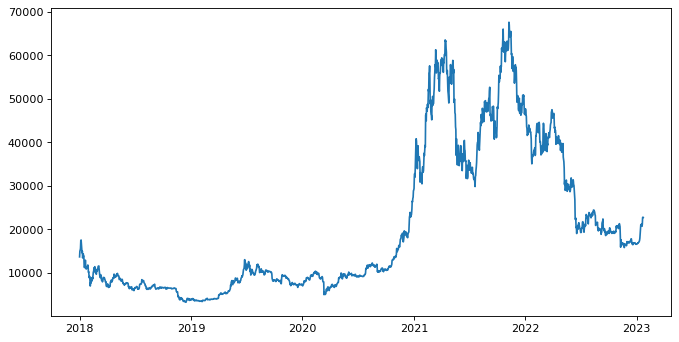

In [4]:
fig = figure(figsize=(10,5), dpi=80)
plt.plot(data)
plt.show()

<h3>Transform in Time Serie</h3>

In [5]:
data = data.rename_axis('Date').reset_index()

data.head(3)

,Date,close
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000


In [6]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'close(t-{i})'] = df['close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)

shifted_df.head(7)

,close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
Date,,,,,,,,
2018-01-08,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,14982.099609,13657.200195
2018-01-09,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,14982.099609
2018-01-10,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000
2018-01-11,13405.799805,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195
2018-01-12,13980.599609,13405.799805,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000
2018-01-13,14360.200195,13980.599609,13405.799805,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000
2018-01-14,13772.000000,14360.200195,13980.599609,13405.799805,14973.299805,14595.400391,15170.099609,16477.599609


In [7]:
shifted_df.tail(7)

,close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
Date,,,,,,,,
2023-01-16,21169.632812,20880.798828,20976.298828,19909.574219,18869.587891,17934.896484,17446.292969,17196.554688
2023-01-17,21161.519531,21169.632812,20880.798828,20976.298828,19909.574219,18869.587891,17934.896484,17446.292969
2023-01-18,20688.781250,21161.519531,21169.632812,20880.798828,20976.298828,19909.574219,18869.587891,17934.896484
2023-01-19,21086.792969,20688.781250,21161.519531,21169.632812,20880.798828,20976.298828,19909.574219,18869.587891
2023-01-20,22676.552734,21086.792969,20688.781250,21161.519531,21169.632812,20880.798828,20976.298828,19909.574219
2023-01-21,22777.625000,22676.552734,21086.792969,20688.781250,21161.519531,21169.632812,20880.798828,20976.298828
2023-01-22,22720.416016,22777.625000,22676.552734,21086.792969,20688.781250,21161.519531,21169.632812,20880.798828


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[15170.09960938, 16477.59960938, 17527.        , ...,
        15201.        , 14982.09960938, 13657.20019531],
       [14595.40039062, 15170.09960938, 16477.59960938, ...,
        15599.20019531, 15201.        , 14982.09960938],
       [14973.29980469, 14595.40039062, 15170.09960938, ...,
        17429.5       , 15599.20019531, 15201.        ],
       ...,
       [22676.55273438, 21086.79296875, 20688.78125   , ...,
        20880.79882812, 20976.29882812, 19909.57421875],
       [22777.625     , 22676.55273438, 21086.79296875, ...,
        21169.6328125 , 20880.79882812, 20976.29882812],
       [22720.41601562, 22777.625     , 22676.55273438, ...,
        21161.51953125, 21169.6328125 , 20880.79882812]])

In [9]:
shifted_df_as_np.shape

(1841, 8)

<h2>MinMaxScaler</h2>

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.62899656, -0.58834683, -0.55572133, ..., -0.62803588,
        -0.63484142, -0.67603209],
       [-0.64686377, -0.62899656, -0.58834683, ..., -0.61565597,
        -0.62803588, -0.63484142],
       [-0.635115  , -0.64686377, -0.62899656, ..., -0.55875257,
        -0.61565597, -0.62803588],
       ...,
       [-0.39562347, -0.44504857, -0.45742262, ..., -0.45145286,
        -0.44848379, -0.4816479 ],
       [-0.39248117, -0.39562347, -0.44504857, ..., -0.4424731 ,
        -0.45145286, -0.44848379],
       [-0.39425978, -0.39248117, -0.39562347, ..., -0.44272534,
        -0.4424731 , -0.45145286]])

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1841, 7), (1841,))

In [12]:
X = dc(np.flip(X, axis=1))
X

array([[-0.67603209, -0.63484142, -0.62803588, ..., -0.55875257,
        -0.55572133, -0.58834683],
       [-0.63484142, -0.62803588, -0.61565597, ..., -0.55572133,
        -0.58834683, -0.62899656],
       [-0.62803588, -0.61565597, -0.55875257, ..., -0.58834683,
        -0.62899656, -0.64686377],
       ...,
       [-0.4816479 , -0.44848379, -0.45145286, ..., -0.44272534,
        -0.45742262, -0.44504857],
       [-0.44848379, -0.45145286, -0.4424731 , ..., -0.45742262,
        -0.44504857, -0.39562347],
       [-0.45145286, -0.4424731 , -0.44272534, ..., -0.44504857,
        -0.39562347, -0.39248117]])

In [13]:
split_index = int(len(X) * 0.95) # 95% of data

split_index

1748

In [14]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1748, 7), (93, 7), (1748,), (93,))

In [15]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1748, 7, 1), (93, 7, 1), (1748, 1), (93, 1))

In [16]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1748, 7, 1]),
 torch.Size([93, 7, 1]),
 torch.Size([1748, 1]),
 torch.Size([93, 1]))

In [17]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [18]:
train_dataset

In [19]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

<h3>Training 1 epoch</h3>

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [24]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.350

Val Loss: 0.015
***************************************************

Epoch: 2
Batch 100, Loss: 0.090

Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Loss: 0.025

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.017

Val Loss: 0.005
***************************************************

Epoch: 5
Batch 100, Loss: 0.013

Val Loss: 0.007
***************************************************

Epoch: 6
Batch 100, Loss: 0.011

Val Loss: 0.008
***************************************************

Epoch: 7
Batch 100, Loss: 0.009

Val Loss: 0.006
***************************************************

Epoch: 8
Batch 100, Loss: 0.007

Val Loss: 0.005
***************************************************

Epoch: 9
Batch 100, Loss: 0.006

Val Loss: 0.004
***************************************************

Epoch: 10
Batch 100, Loss: 0.005

Val Loss: 0.003
********************************

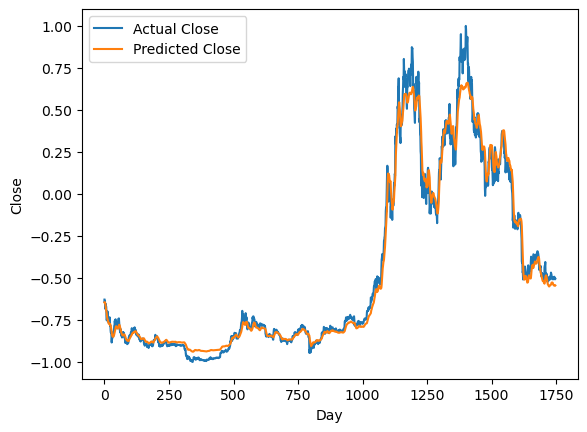

In [25]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [26]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([14614.95210625, 14697.52144612, 14561.94576492, ...,
       17952.47660326, 17937.19855298, 17884.75778133])

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([15170.09997312, 14595.40064977, 14973.29897686, ...,
       19139.53452236, 19053.74047668, 19172.46793279])

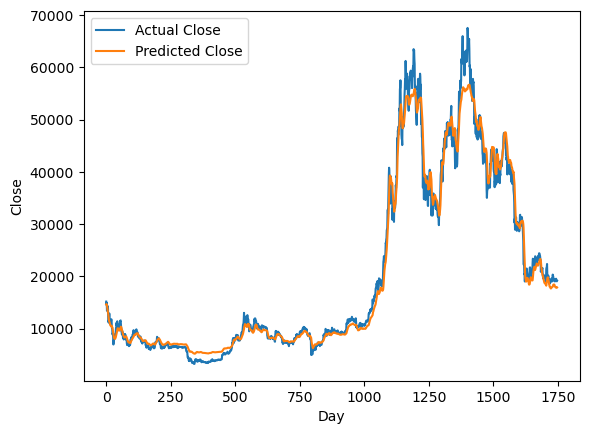

In [28]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [29]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([17881.95677349, 17896.5101277 , 17957.7028506 , 17934.7963197 ,
       18090.16502275, 18379.433787  , 18553.4547866 , 18774.28195002,
       19016.60267872, 19162.5139063 , 19297.00637777, 19336.78030563,
       19232.57744595, 19204.10724308, 19330.16985045, 19436.43560159,
       19484.04314891, 19485.49254105, 19079.06841271, 18245.02567168,
       17836.74187353, 17218.03739418, 16598.14617709, 15987.25231097,
       15519.61437069, 15349.16317027, 15421.10938596, 15318.38275902,
       15282.4585394 , 15276.24110722, 15238.30576014, 15089.85042756,
       15007.73737781, 15022.26197424, 15023.88774744, 15009.71399593,
       14987.32893946, 15008.19941949, 15037.90045537, 15069.86952155,
       15185.60041691, 15242.90508786, 15332.74439469, 15387.89031491,
       15487.34047204, 15570.55015182, 15648.23450335, 15597.41375334,
       15647.94692554, 15656.20424297, 15683.97467317, 15682.37382338,
       15717.01161161, 15843.90244306, 15983.75344766, 15988.74196401,
      

In [30]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([19208.18893075, 19567.00742896, 19345.57251778, 20095.857264  ,
       20770.44098697, 20285.8359561 , 20595.35115653, 20818.47702522,
       20635.60342214, 20495.77350657, 20485.27308226, 20159.50398419,
       20209.98826816, 21147.23022233, 21282.69183101, 20926.48645647,
       20602.81667639, 18541.27107352, 15880.77950381, 17586.77157517,
       17034.29243034, 16799.18607022, 16353.36569955, 16618.19993614,
       16884.61393349, 16669.43863256, 16687.51769068, 16697.77654964,
       16711.54769221, 16291.83171765, 15787.28412446, 16189.77035404,
       16610.70757569, 16604.46522009, 16521.84219903, 16464.28062524,
       16444.62755792, 16217.32222511, 16444.98223722, 17168.56634268,
       16967.13342654, 17088.6599733 , 16908.23557454, 17130.4872067 ,
       16974.82709147, 17089.50353487, 16848.12606137, 17233.47457085,
       17133.15209437, 17128.72531334, 17104.19300924, 17206.43842264,
       17781.31796143, 17815.65091718, 17364.86503638, 16647.4849428 ,
      

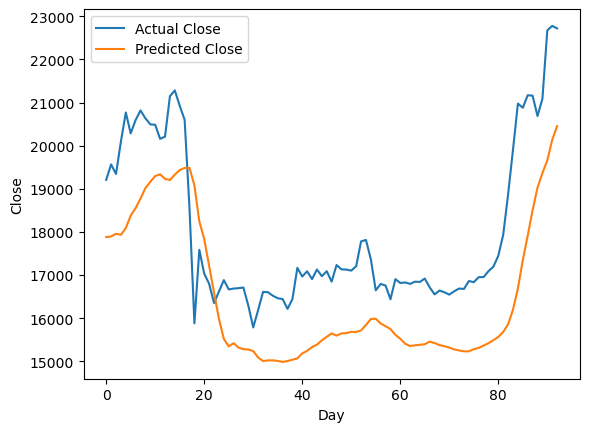

In [31]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()